In [59]:
import os
import logging

import numpy as np

import torch
from torch import nn

import torchvision

import matplotlib.pyplot as plt

logging.basicConfig(format='%(asctime)s %(levelname)s: %(message)s', datefmt='%Y-%m-%d %H:%M:%S', level=logging.INFO)

device = torch.device('cuda')

logging.info(f'Using device {device}')

2021-12-29 17:03:20 INFO: Using device cuda


In [60]:
BATCH_SIZE = 256
GAMMA = 0.001
LR = 1e-4
LATENT = 2
LOG_INT = 50

DATA = os.environ['DATA']

train = torchvision.datasets.MNIST(f'{DATA}/vision', train=True, download=True)
train = train.data / 255.0
train = train * 2 - 1
train = train.unsqueeze(1)

logging.info(train.shape)

2021-12-29 17:03:20 INFO: torch.Size([60000, 1, 28, 28])


In [61]:
C = 16
class GNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Unflatten(1, (LATENT, 1, 1)),
            
            nn.ConvTranspose2d(LATENT, 2 * C, 7, 7),
            nn.ReLU(True),

            nn.ConvTranspose2d(2 * C, C, 4, 2, 1),
            nn.ReLU(True),

            nn.ConvTranspose2d(C, 1, 4, 2, 1),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.net(x)
        return x

class DNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(1, C, 4, 2, 1),
            nn.ReLU(True),

            nn.Conv2d(C, 2 * C, 4, 2, 1),
            nn.ReLU(True),

            nn.Conv2d(2 * C, 1, 7, 7),
            
            nn.Flatten(),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.net(x)
        return x


train = train.to(torch.float).to(device)

G = GNet().to(device)
D = DNet().to(device)
GO = torch.optim.Adam(G.parameters(), lr=LR, betas=(0.5, 0.999))
DO = torch.optim.Adam(D.parameters(), lr=LR, betas=(0.5, 0.999))

def gen(n):
    z = torch.empty((n, LATENT), dtype=torch.float, device=device).uniform_(-1, 1)
    return G(z)

logging.info(f'G: {sum(p.numel() for p in G.parameters())}')
logging.info(f'D: {sum(p.numel() for p in D.parameters())}')

2021-12-29 17:03:20 INFO: G: 11633
2021-12-29 17:03:20 INFO: D: 10065


In [62]:
def plot_latent_space(n=30, figsize=15):
    digit_size = 28
    scale = 1
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            with torch.no_grad():
                x_decoded = gen(1)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            digit = torch.clamp(digit * 0.5 + 0.5, 0.0, 1.0)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit.cpu()

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

2021-12-29 17:03:21 INFO: 50 0.526 0.666
2021-12-29 17:03:21 INFO: 100 0.392 0.861
2021-12-29 17:03:21 INFO: 150 0.292 1.249
2021-12-29 17:03:21 INFO: 200 0.232 1.637
2021-12-29 17:03:21 INFO: 250 0.197 1.890
2021-12-29 17:03:21 INFO: 300 0.173 2.090
2021-12-29 17:03:22 INFO: 350 0.153 2.300
2021-12-29 17:03:22 INFO: 400 0.136 2.516
2021-12-29 17:03:22 INFO: 450 0.122 2.727
2021-12-29 17:03:22 INFO: 500 0.111 2.929
2021-12-29 17:03:22 INFO: 550 0.102 3.123
2021-12-29 17:03:23 INFO: 600 0.094 3.309
2021-12-29 17:03:23 INFO: 650 0.087 3.489
2021-12-29 17:03:23 INFO: 700 0.081 3.661
2021-12-29 17:03:23 INFO: 750 0.076 3.825
2021-12-29 17:03:23 INFO: 800 0.072 3.983
2021-12-29 17:03:23 INFO: 850 0.068 4.134
2021-12-29 17:03:24 INFO: 900 0.064 4.281
2021-12-29 17:03:24 INFO: 950 0.061 4.407
2021-12-29 17:03:24 INFO: 1000 0.058 4.486
2021-12-29 17:03:24 INFO: 1050 0.056 4.599
2021-12-29 17:03:24 INFO: 1100 0.053 4.675
2021-12-29 17:03:24 INFO: 1150 0.051 4.692
2021-12-29 17:03:25 INFO: 1200 

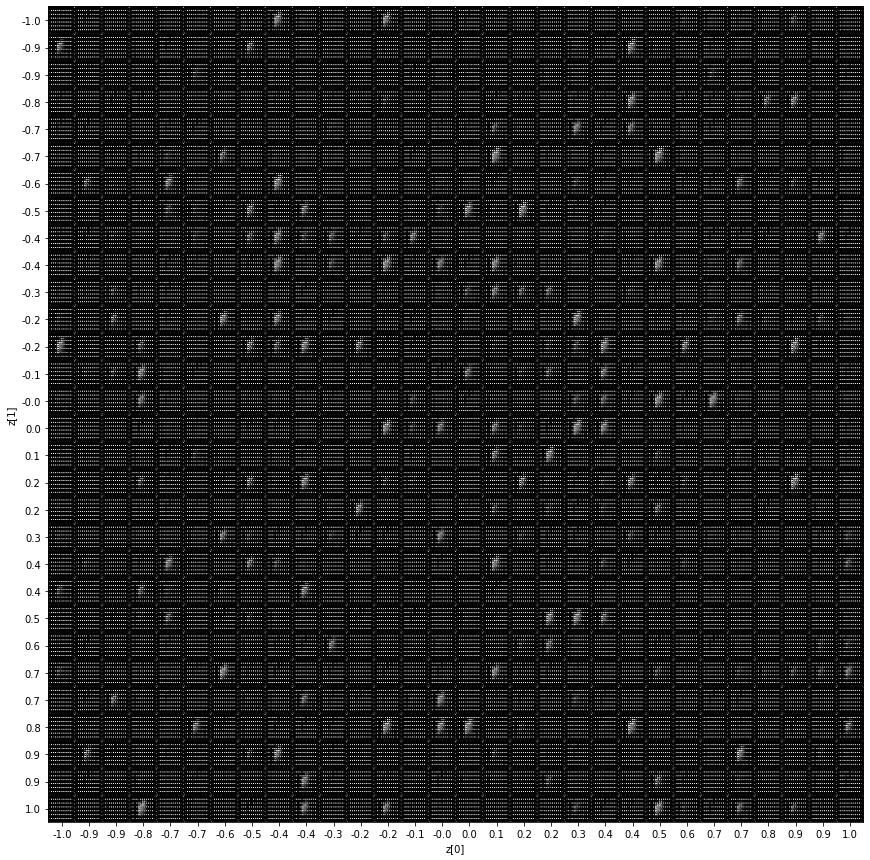

2021-12-29 17:03:32 INFO: 3050 0.011 6.815
2021-12-29 17:03:32 INFO: 3100 0.010 6.927
2021-12-29 17:03:32 INFO: 3150 0.010 7.050
2021-12-29 17:03:32 INFO: 3200 0.009 7.181
2021-12-29 17:03:32 INFO: 3250 0.009 7.259
2021-12-29 17:03:32 INFO: 3300 0.009 7.304
2021-12-29 17:03:33 INFO: 3350 0.008 7.359
2021-12-29 17:03:33 INFO: 3400 0.008 7.419
2021-12-29 17:03:33 INFO: 3450 0.008 7.489
2021-12-29 17:03:33 INFO: 3500 0.008 7.560
2021-12-29 17:03:33 INFO: 3550 0.008 7.629
2021-12-29 17:03:34 INFO: 3600 0.008 7.706
2021-12-29 17:03:34 INFO: 3650 0.008 7.778
2021-12-29 17:03:34 INFO: 3700 0.007 7.856
2021-12-29 17:03:34 INFO: 3750 0.007 7.933
2021-12-29 17:03:34 INFO: 3800 0.007 8.002
2021-12-29 17:03:34 INFO: 3850 0.007 8.042
2021-12-29 17:03:35 INFO: 3900 0.007 8.047
2021-12-29 17:03:35 INFO: 3950 0.009 7.965
2021-12-29 17:03:35 INFO: 4000 0.009 7.865
2021-12-29 17:03:35 INFO: 4050 0.009 7.801
2021-12-29 17:03:35 INFO: 4100 0.009 7.761
2021-12-29 17:03:35 INFO: 4150 0.008 7.707
2021-12-29 

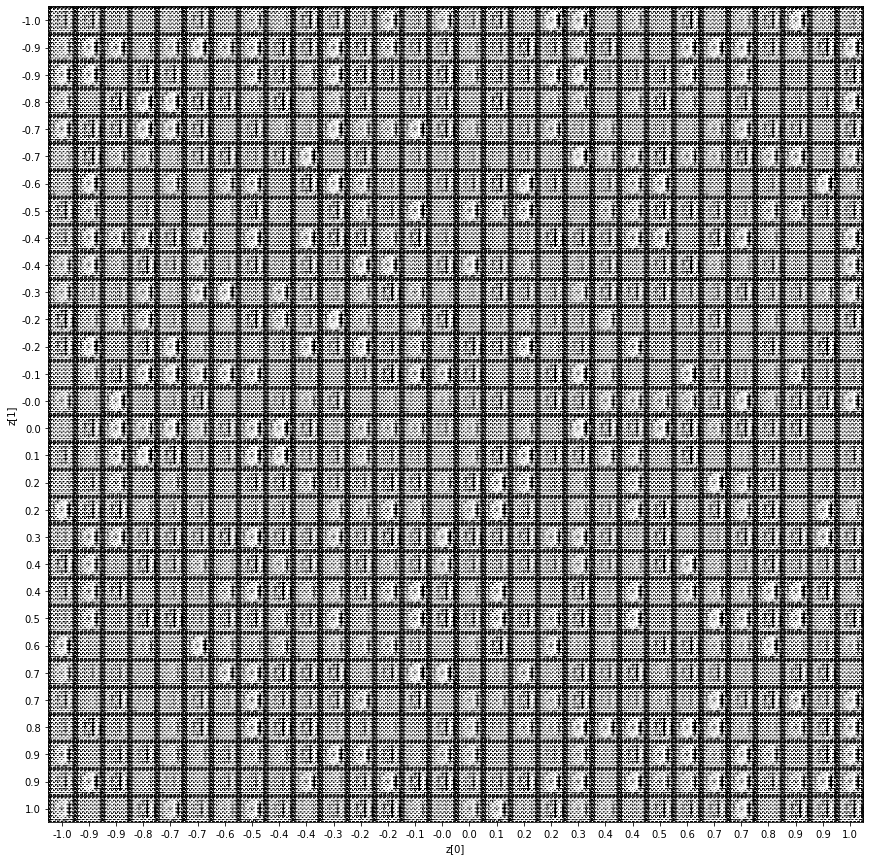

2021-12-29 17:03:42 INFO: 6050 0.017 6.641
2021-12-29 17:03:42 INFO: 6100 0.016 6.651
2021-12-29 17:03:43 INFO: 6150 0.015 6.667
2021-12-29 17:03:43 INFO: 6200 0.014 6.685
2021-12-29 17:03:43 INFO: 6250 0.014 6.699
2021-12-29 17:03:43 INFO: 6300 0.013 6.724
2021-12-29 17:03:43 INFO: 6350 0.013 6.755
2021-12-29 17:03:43 INFO: 6400 0.012 6.786
2021-12-29 17:03:44 INFO: 6450 0.011 6.816
2021-12-29 17:03:44 INFO: 6500 0.011 6.842
2021-12-29 17:03:44 INFO: 6550 0.010 6.871
2021-12-29 17:03:44 INFO: 6600 0.010 6.905
2021-12-29 17:03:44 INFO: 6650 0.009 6.942
2021-12-29 17:03:44 INFO: 6700 0.009 6.984
2021-12-29 17:03:45 INFO: 6750 0.009 7.029
2021-12-29 17:03:45 INFO: 6800 0.008 7.077
2021-12-29 17:03:45 INFO: 6850 0.008 7.128
2021-12-29 17:03:45 INFO: 6900 0.007 7.180
2021-12-29 17:03:45 INFO: 6950 0.007 7.234
2021-12-29 17:03:46 INFO: 7000 0.007 7.289
2021-12-29 17:03:46 INFO: 7050 0.006 7.344
2021-12-29 17:03:46 INFO: 7100 0.006 7.400
2021-12-29 17:03:46 INFO: 7150 0.006 7.456
2021-12-29 

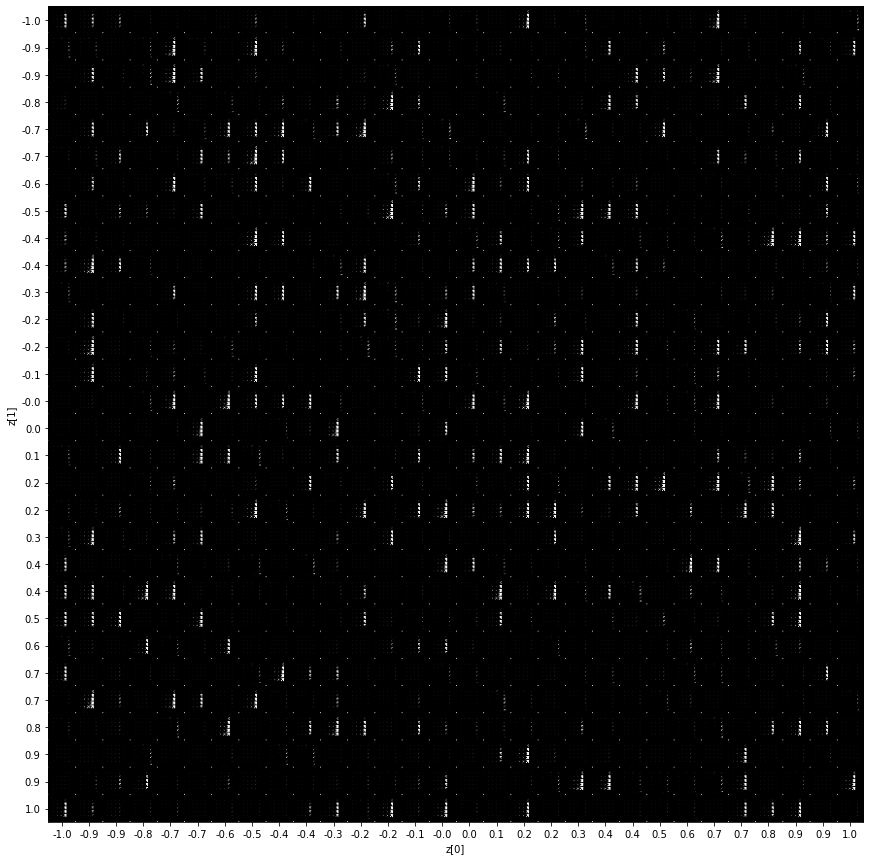

2021-12-29 17:03:53 INFO: 9050 0.005 7.534
2021-12-29 17:03:53 INFO: 9100 0.006 7.481
2021-12-29 17:03:53 INFO: 9150 0.006 7.413
2021-12-29 17:03:53 INFO: 9200 0.006 7.392
2021-12-29 17:03:54 INFO: 9250 0.006 7.398
2021-12-29 17:03:54 INFO: 9300 0.006 7.420
2021-12-29 17:03:54 INFO: 9350 0.006 7.466
2021-12-29 17:03:54 INFO: 9400 0.006 7.525
2021-12-29 17:03:54 INFO: 9450 0.006 7.578
2021-12-29 17:03:54 INFO: 9500 0.007 7.627
2021-12-29 17:03:55 INFO: 9550 0.007 7.636
2021-12-29 17:03:55 INFO: 9600 0.007 7.568
2021-12-29 17:03:55 INFO: 9650 0.007 7.495
2021-12-29 17:03:55 INFO: 9700 0.007 7.442
2021-12-29 17:03:55 INFO: 9750 0.007 7.411
2021-12-29 17:03:55 INFO: 9800 0.007 7.393
2021-12-29 17:03:56 INFO: 9850 0.007 7.388
2021-12-29 17:03:56 INFO: 9900 0.007 7.353
2021-12-29 17:03:56 INFO: 9950 0.007 7.301
2021-12-29 17:03:56 INFO: 10000 0.007 7.256
2021-12-29 17:03:56 INFO: 10050 0.007 7.211
2021-12-29 17:03:56 INFO: 10100 0.008 7.180
2021-12-29 17:03:57 INFO: 10150 0.011 7.179
2021-12

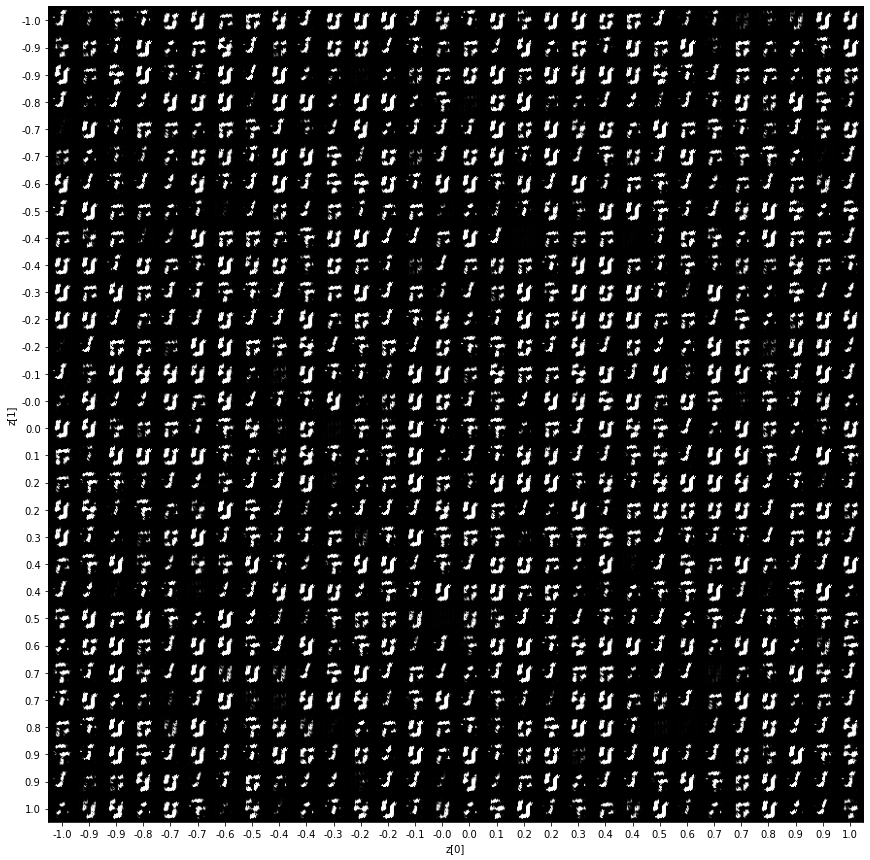

2021-12-29 17:04:04 INFO: 12050 0.097 4.395
2021-12-29 17:04:04 INFO: 12100 0.098 4.330
2021-12-29 17:04:04 INFO: 12150 0.099 4.259
2021-12-29 17:04:04 INFO: 12200 0.101 4.178
2021-12-29 17:04:04 INFO: 12250 0.103 4.108
2021-12-29 17:04:04 INFO: 12300 0.103 4.052
2021-12-29 17:04:05 INFO: 12350 0.103 4.008
2021-12-29 17:04:05 INFO: 12400 0.102 3.972
2021-12-29 17:04:05 INFO: 12450 0.100 3.943
2021-12-29 17:04:05 INFO: 12500 0.099 3.917
2021-12-29 17:04:05 INFO: 12550 0.097 3.893
2021-12-29 17:04:05 INFO: 12600 0.096 3.872
2021-12-29 17:04:06 INFO: 12650 0.095 3.855
2021-12-29 17:04:06 INFO: 12700 0.095 3.830
2021-12-29 17:04:06 INFO: 12750 0.095 3.800
2021-12-29 17:04:06 INFO: 12800 0.095 3.782
2021-12-29 17:04:06 INFO: 12850 0.094 3.768
2021-12-29 17:04:06 INFO: 12900 0.093 3.758
2021-12-29 17:04:07 INFO: 12950 0.093 3.751
2021-12-29 17:04:07 INFO: 13000 0.094 3.739
2021-12-29 17:04:07 INFO: 13050 0.095 3.714
2021-12-29 17:04:07 INFO: 13100 0.096 3.688
2021-12-29 17:04:07 INFO: 13150 

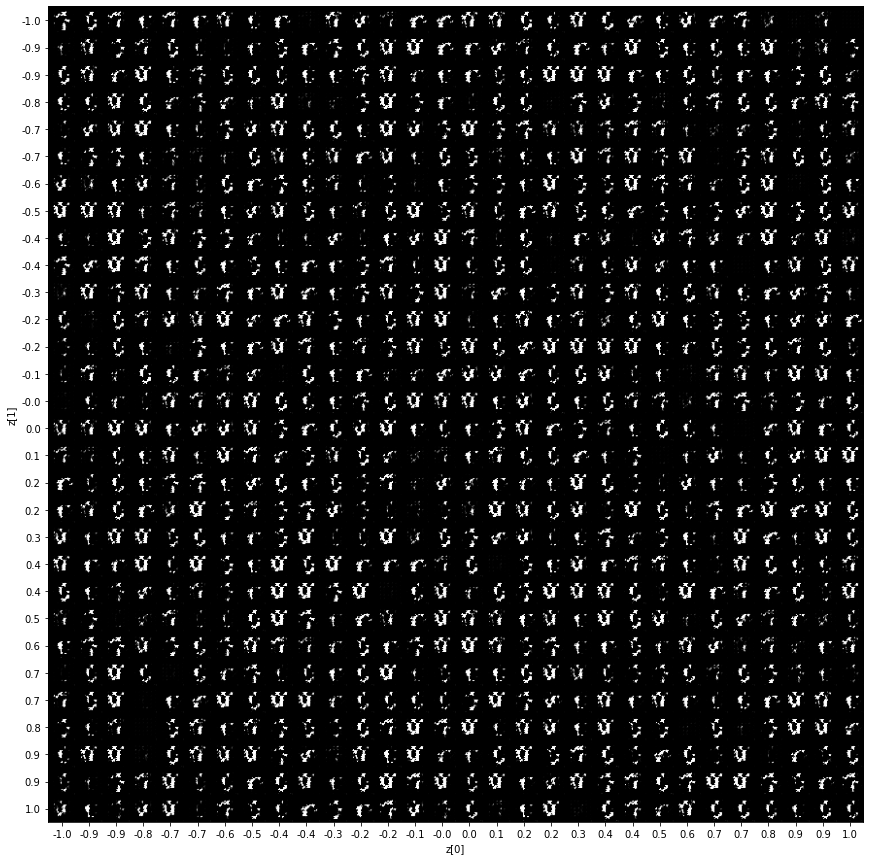

2021-12-29 17:04:14 INFO: 15050 0.042 4.638
2021-12-29 17:04:14 INFO: 15100 0.041 4.656
2021-12-29 17:04:14 INFO: 15150 0.040 4.674
2021-12-29 17:04:15 INFO: 15200 0.039 4.695
2021-12-29 17:04:15 INFO: 15250 0.038 4.713
2021-12-29 17:04:15 INFO: 15300 0.037 4.735
2021-12-29 17:04:15 INFO: 15350 0.036 4.764
2021-12-29 17:04:15 INFO: 15400 0.035 4.793
2021-12-29 17:04:15 INFO: 15450 0.034 4.826
2021-12-29 17:04:16 INFO: 15500 0.033 4.864
2021-12-29 17:04:16 INFO: 15550 0.032 4.904
2021-12-29 17:04:16 INFO: 15600 0.031 4.950
2021-12-29 17:04:16 INFO: 15650 0.030 4.977
2021-12-29 17:04:16 INFO: 15700 0.030 4.978
2021-12-29 17:04:16 INFO: 15750 0.030 4.983
2021-12-29 17:04:17 INFO: 15800 0.029 4.996
2021-12-29 17:04:17 INFO: 15850 0.029 5.008
2021-12-29 17:04:17 INFO: 15900 0.028 5.026
2021-12-29 17:04:17 INFO: 15950 0.027 5.048
2021-12-29 17:04:17 INFO: 16000 0.027 5.077
2021-12-29 17:04:17 INFO: 16050 0.026 5.105
2021-12-29 17:04:18 INFO: 16100 0.026 5.130
2021-12-29 17:04:18 INFO: 16150 

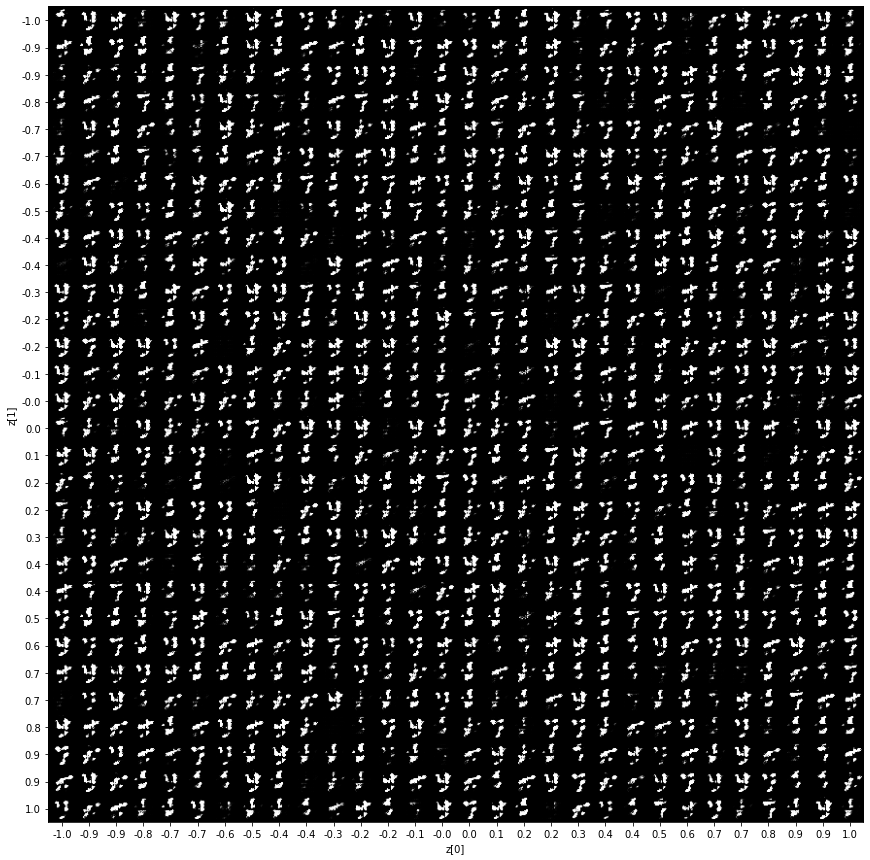

2021-12-29 17:04:25 INFO: 18050 0.102 3.603
2021-12-29 17:04:25 INFO: 18100 0.100 3.600
2021-12-29 17:04:25 INFO: 18150 0.098 3.600
2021-12-29 17:04:25 INFO: 18200 0.096 3.600
2021-12-29 17:04:26 INFO: 18250 0.094 3.599
2021-12-29 17:04:26 INFO: 18300 0.093 3.592
2021-12-29 17:04:26 INFO: 18350 0.092 3.582
2021-12-29 17:04:26 INFO: 18400 0.092 3.578
2021-12-29 17:04:26 INFO: 18450 0.091 3.580
2021-12-29 17:04:27 INFO: 18500 0.089 3.588
2021-12-29 17:04:27 INFO: 18550 0.088 3.597
2021-12-29 17:04:27 INFO: 18600 0.087 3.597
2021-12-29 17:04:27 INFO: 18650 0.087 3.583
2021-12-29 17:04:27 INFO: 18700 0.087 3.567
2021-12-29 17:04:27 INFO: 18750 0.086 3.551
2021-12-29 17:04:28 INFO: 18800 0.085 3.538
2021-12-29 17:04:28 INFO: 18850 0.084 3.530
2021-12-29 17:04:28 INFO: 18900 0.083 3.520
2021-12-29 17:04:28 INFO: 18950 0.084 3.510
2021-12-29 17:04:28 INFO: 19000 0.086 3.491
2021-12-29 17:04:29 INFO: 19050 0.089 3.463
2021-12-29 17:04:29 INFO: 19100 0.090 3.456
2021-12-29 17:04:29 INFO: 19150 

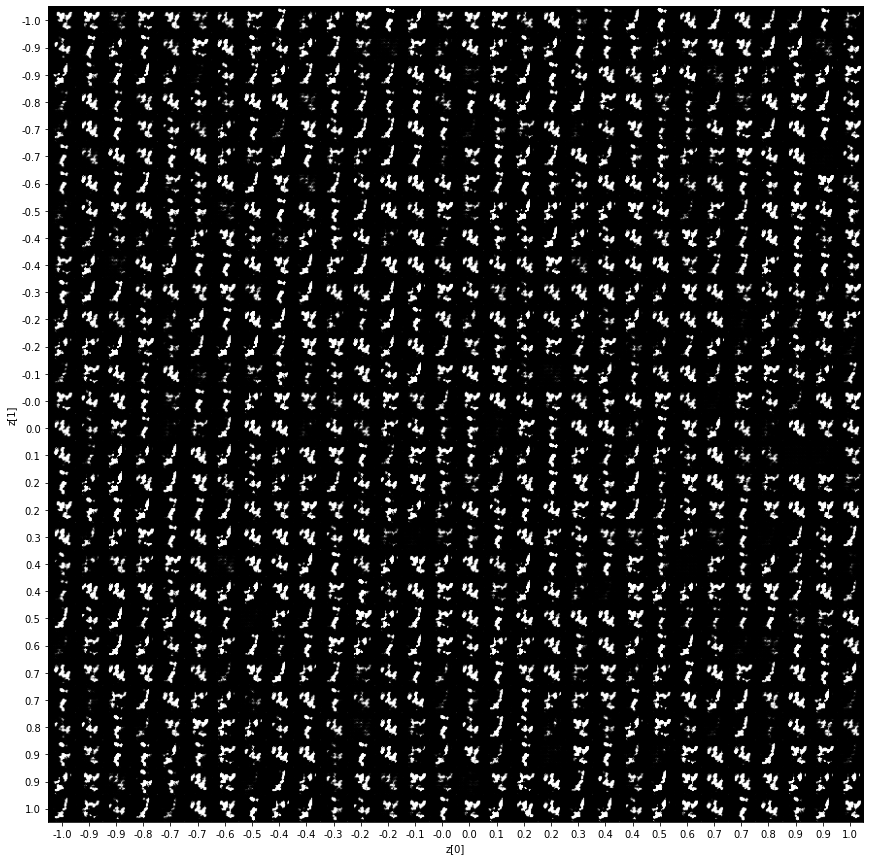

2021-12-29 17:04:36 INFO: 21050 0.094 3.328
2021-12-29 17:04:36 INFO: 21100 0.094 3.338
2021-12-29 17:04:36 INFO: 21150 0.093 3.349
2021-12-29 17:04:36 INFO: 21200 0.092 3.362
2021-12-29 17:04:36 INFO: 21250 0.090 3.376
2021-12-29 17:04:36 INFO: 21300 0.088 3.391
2021-12-29 17:04:37 INFO: 21350 0.086 3.410
2021-12-29 17:04:37 INFO: 21400 0.085 3.431
2021-12-29 17:04:37 INFO: 21450 0.083 3.456
2021-12-29 17:04:37 INFO: 21500 0.082 3.480
2021-12-29 17:04:37 INFO: 21550 0.080 3.503
2021-12-29 17:04:37 INFO: 21600 0.079 3.523
2021-12-29 17:04:38 INFO: 21650 0.078 3.539
2021-12-29 17:04:38 INFO: 21700 0.076 3.552
2021-12-29 17:04:38 INFO: 21750 0.075 3.562
2021-12-29 17:04:38 INFO: 21800 0.075 3.574
2021-12-29 17:04:38 INFO: 21850 0.074 3.591
2021-12-29 17:04:38 INFO: 21900 0.073 3.601
2021-12-29 17:04:39 INFO: 21950 0.073 3.611
2021-12-29 17:04:39 INFO: 22000 0.073 3.617
2021-12-29 17:04:39 INFO: 22050 0.073 3.620
2021-12-29 17:04:39 INFO: 22100 0.072 3.623
2021-12-29 17:04:39 INFO: 22150 

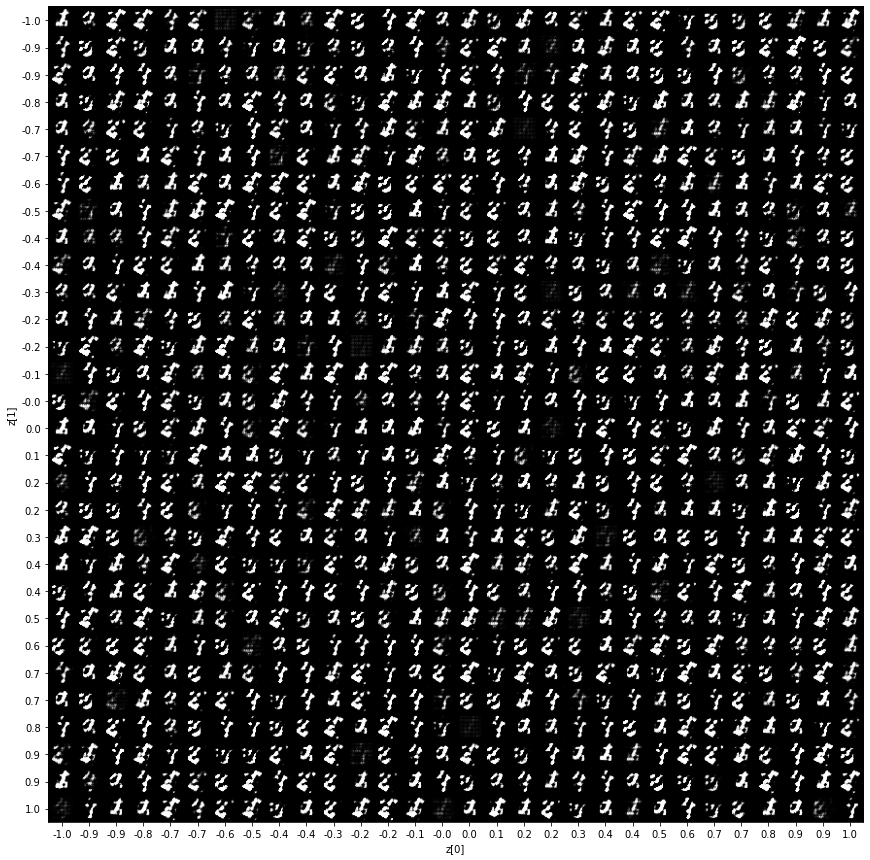

2021-12-29 17:04:46 INFO: 24050 0.107 3.399
2021-12-29 17:04:46 INFO: 24100 0.107 3.394
2021-12-29 17:04:46 INFO: 24150 0.106 3.400
2021-12-29 17:04:47 INFO: 24200 0.106 3.400
2021-12-29 17:04:47 INFO: 24250 0.105 3.400
2021-12-29 17:04:47 INFO: 24300 0.104 3.399
2021-12-29 17:04:47 INFO: 24350 0.103 3.402
2021-12-29 17:04:47 INFO: 24400 0.102 3.403
2021-12-29 17:04:47 INFO: 24450 0.101 3.405
2021-12-29 17:04:48 INFO: 24500 0.101 3.405
2021-12-29 17:04:48 INFO: 24550 0.100 3.404
2021-12-29 17:04:48 INFO: 24600 0.101 3.397
2021-12-29 17:04:48 INFO: 24650 0.102 3.394
2021-12-29 17:04:48 INFO: 24700 0.103 3.391
2021-12-29 17:04:48 INFO: 24750 0.104 3.388
2021-12-29 17:04:49 INFO: 24800 0.105 3.378
2021-12-29 17:04:49 INFO: 24850 0.105 3.368
2021-12-29 17:04:49 INFO: 24900 0.106 3.357
2021-12-29 17:04:49 INFO: 24950 0.105 3.350
2021-12-29 17:04:49 INFO: 25000 0.105 3.347
2021-12-29 17:04:49 INFO: 25050 0.104 3.345
2021-12-29 17:04:50 INFO: 25100 0.103 3.345
2021-12-29 17:04:50 INFO: 25150 

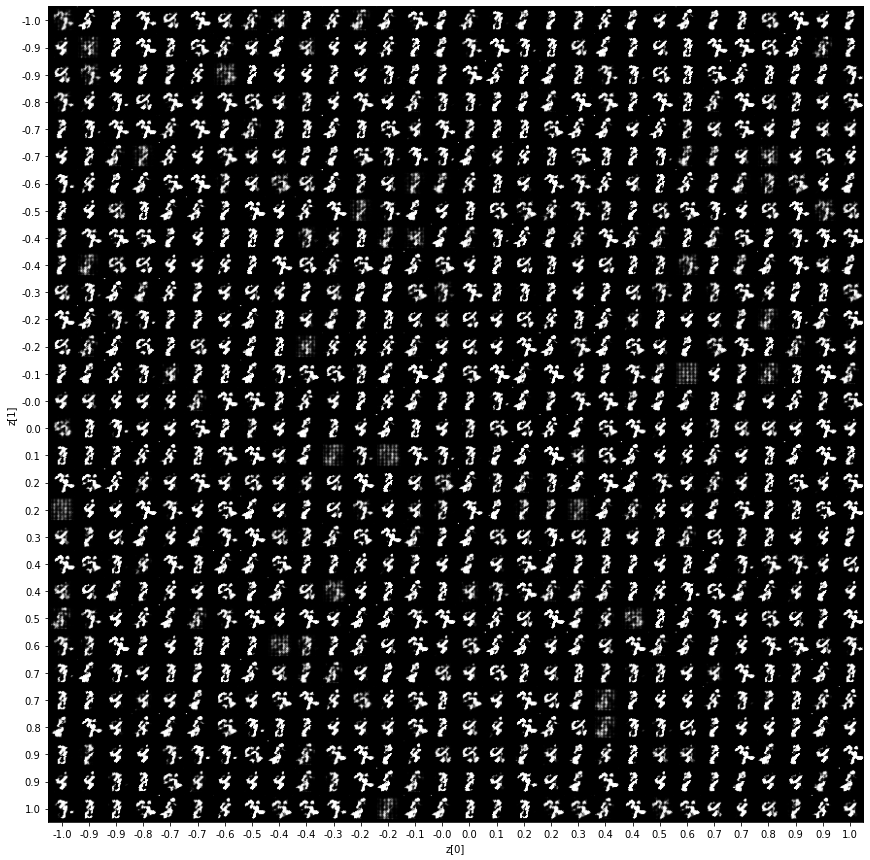

2021-12-29 17:04:57 INFO: 27050 0.118 3.374
2021-12-29 17:04:57 INFO: 27100 0.121 3.355
2021-12-29 17:04:57 INFO: 27150 0.123 3.337
2021-12-29 17:04:57 INFO: 27200 0.124 3.324
2021-12-29 17:04:57 INFO: 27250 0.125 3.308
2021-12-29 17:04:58 INFO: 27300 0.126 3.298
2021-12-29 17:04:58 INFO: 27350 0.127 3.291
2021-12-29 17:04:58 INFO: 27400 0.127 3.281
2021-12-29 17:04:58 INFO: 27450 0.128 3.272
2021-12-29 17:04:58 INFO: 27500 0.127 3.267
2021-12-29 17:04:58 INFO: 27550 0.127 3.260
2021-12-29 17:04:58 INFO: 27600 0.127 3.250
2021-12-29 17:04:59 INFO: 27650 0.127 3.234
2021-12-29 17:04:59 INFO: 27700 0.127 3.219
2021-12-29 17:04:59 INFO: 27750 0.127 3.208
2021-12-29 17:04:59 INFO: 27800 0.127 3.196
2021-12-29 17:04:59 INFO: 27850 0.127 3.185
2021-12-29 17:04:59 INFO: 27900 0.126 3.179
2021-12-29 17:05:00 INFO: 27950 0.125 3.173
2021-12-29 17:05:00 INFO: 28000 0.124 3.168
2021-12-29 17:05:00 INFO: 28050 0.123 3.164
2021-12-29 17:05:00 INFO: 28100 0.121 3.162
2021-12-29 17:05:00 INFO: 28150 

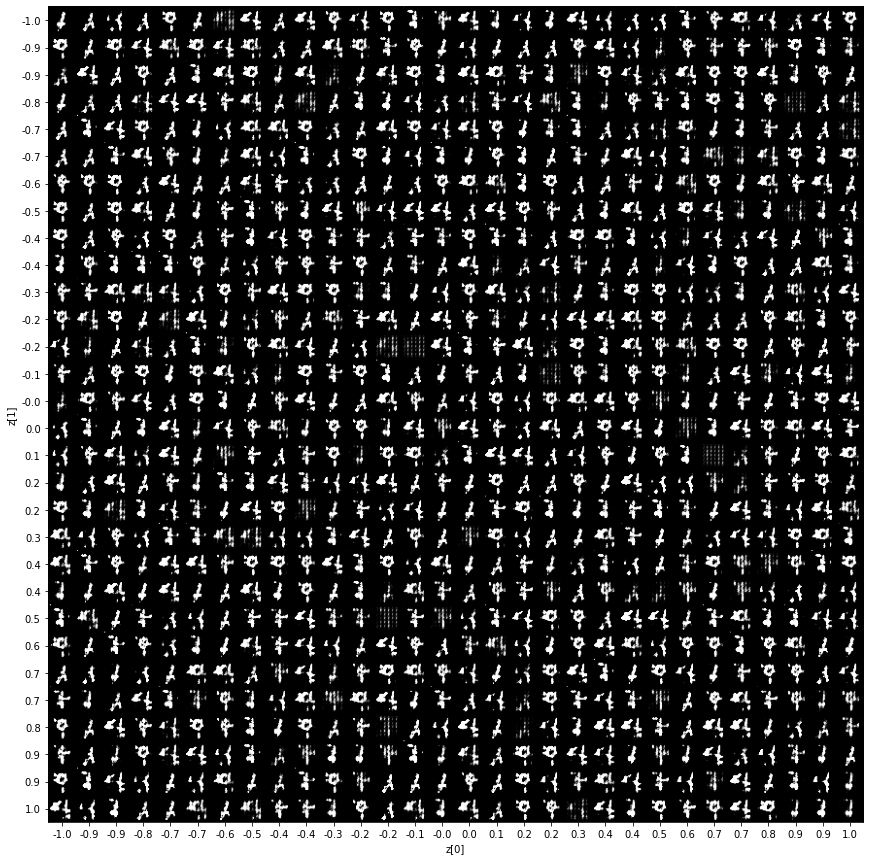

2021-12-29 17:05:07 INFO: 30050 0.134 3.144
2021-12-29 17:05:07 INFO: 30100 0.134 3.172
2021-12-29 17:05:08 INFO: 30150 0.132 3.217
2021-12-29 17:05:08 INFO: 30200 0.131 3.240
2021-12-29 17:05:08 INFO: 30250 0.131 3.257
2021-12-29 17:05:08 INFO: 30300 0.130 3.276
2021-12-29 17:05:08 INFO: 30350 0.129 3.294
2021-12-29 17:05:08 INFO: 30400 0.129 3.302
2021-12-29 17:05:09 INFO: 30450 0.128 3.305
2021-12-29 17:05:09 INFO: 30500 0.127 3.313
2021-12-29 17:05:09 INFO: 30550 0.125 3.324


KeyboardInterrupt: 

In [63]:
wd_loss = 100
wg_loss = 100
count = 0

lossf = nn.BCELoss()

while True:
    count += 1
    gamma = max(1 / count, GAMMA)

    G.train()
    D.train()

    idx = torch.randint(train.shape[0], (BATCH_SIZE,))
    real = train[idx]
    fake = gen(BATCH_SIZE)

    vf = torch.full((BATCH_SIZE, 1,), 1, dtype=torch.float, device=device)
    ff = torch.full((BATCH_SIZE, 1,), 0, dtype=torch.float, device=device)

    DO.zero_grad()

    d_loss = (lossf(D(real), vf) + lossf(D(fake.detach()), ff)) * 0.5
    d_loss.backward()

    DO.step()
    wd_loss = d_loss.item() * gamma + wd_loss * (1 - gamma)
    
    GO.zero_grad()

    g_loss = lossf(D(fake), vf)
    g_loss.backward()

    GO.step()
    wg_loss = g_loss.item() * gamma + wg_loss * (1 - gamma)

    if count % LOG_INT == 0:
        logging.info(f'{count} {wd_loss:.3f} {wg_loss:.3f}')

    if count % 3000 == 0:
        G.eval()
        plot_latent_space()